### mission
- 쿠팡 리뷰 데이터를 이용해 연관분석, 토픽 관계성 분석

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import time

<html dir="ltr" lang="ko"><head><script async="" crossorigin="anonymous" integrity="sha384-yPDV9GA2W2IAM3JTAbMwWuXjBgWnp1u2X1qK1RgwJLMwY4CuscUKKvsDtQ3Iju+L" nonce="" src="https://www.gstatic.com/recaptcha/releases/ecapuzyywmdXQ5gJHS3JQiXe/recaptcha__ko.js" type="text/javascript"></script><script async="" nonce="" src="https://www.google-analytics.com/analytics.js"></script><script async="" nonce="" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.2cdKFnNWjuc.O/m=gapi_iframes,googleapis_client/rt=j/sv=1/d=1/ed=1/rs=AHpOoo-rZMnae0kdWLu9CWmKEzOTJj_h7w/cb=gapi.loaded_0"></script><base href="https://play.google.com/"/><meta content="origin" name="referrer"/><meta content="width=device-width, initial-scale=1" name="viewport"/><link href="/opensearch.xml" rel="search" title="Google Play" type="application/opensearchdescription+xml"/><link href="//www.gstatic.com/android/market_images/web/favicon_v2.ico" rel="shortcut icon"/><script data-id="_gd" nonce="">window.WIZ_global_dat
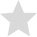
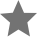
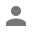
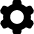
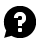
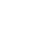
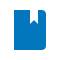
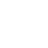
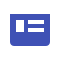
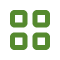
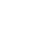
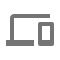
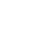
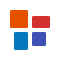
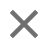
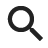
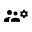
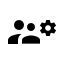
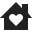
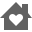
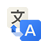
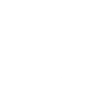
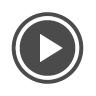
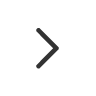
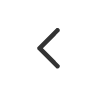
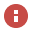
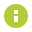
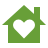
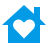
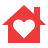
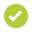
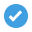
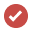
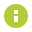

In [3]:
url = 'https://play.google.com/store/apps/details?id=com.coupang.mobile&hl=ko&gl=US&showAllReviews=true'
driver = webdriver.Chrome('c:/pydata/chromedriver.exe')
driver.get(url)
n = 20
for i in range(n):
    try:
        driver.find_element_by_css_selector('#fcxH9b > div.WpDbMd > c-wiz:nth-child(4) > div > div.ZfcPIb > div > div > main > div > div.W4P4ne > div:nth-child(2) > div.PFAhAf > div > span > span').click()
        time.sleep(2)
    except:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(2)
html = driver.page_source
soup = bs(html , 'html.parser')
soup

In [4]:
body_soup = soup.find_all('div', class_="UD7Dzf")
new_list = []
for i in body_soup:
    body = i.find('span', jsname="bN97Pc").text
    new_list.append(body)

In [8]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import re
from konlpy.tag import Okt


In [16]:
dataset = []
df = pd.DataFrame(new_list, columns=['댓글'])
okt= Okt()
for txt in tqdm(df['댓글']):
    dataset.append(okt.nouns(re.sub('[^가-힣a-zA-Z ]', "", txt)))
tren = TransactionEncoder()
tren_ary = tren.fit(dataset).transform(dataset)

tren_df = pd.DataFrame(tren_ary, columns=tren.columns_)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.22it/s]


In [23]:
from mlxtend.frequent_patterns import association_rules
apr_item = apriori(tren_df, min_support = 0.1, use_colnames = True)
association_rules(apr_item, metric = 'lift', min_threshold = 1.0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(로켓),(배송),0.215,0.305,0.17,0.790698,2.592451,0.104425,3.320556
1,(배송),(로켓),0.305,0.215,0.17,0.557377,2.592451,0.104425,1.773519
2,(쿠팡),(앱),0.435,0.170,0.10,0.229885,1.352265,0.026050,1.077761
3,(앱),(쿠팡),0.170,0.435,0.10,0.588235,1.352265,0.026050,1.372143


In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from apyori import apriori

In [35]:
support_res = (list(apriori(dataset, min_support = 0.05)))
df1 = pd.DataFrame()
df1 = pd.DataFrame(support_res)
df1['length'] = df1['items'].apply(lambda x: len(x))

In [39]:
df1

,items,support,ordered_statistics,length
0,(가격),0.055,"[((), (가격), 0.055, 1.0)]",1
1,(개),0.060,"[((), (개), 0.06, 1.0)]",1
2,(거),0.075,"[((), (거), 0.075, 1.0)]",1
3,(검색),0.055,"[((), (검색), 0.055, 1.0)]",1
4,(것),0.100,"[((), (것), 0.1, 1.0)]",1
...,...,...,...,...
83,"(쿠팡, 왜)",0.075,"[((), (쿠팡, 왜), 0.075, 1.0), ((왜), (쿠팡), 0.5172...",2
84,"(쿠팡, 좀)",0.080,"[((), (쿠팡, 좀), 0.08, 1.0), ((좀), (쿠팡), 0.55172...",2
85,"(쿠팡, 주문)",0.055,"[((), (쿠팡, 주문), 0.055, 1.0), ((주문), (쿠팡), 0.42...",2
86,"(로켓, 배송, 주문)",0.060,"[((), (로켓, 배송, 주문), 0.06, 1.0), ((로켓), (배송, 주문...",3


In [48]:
    df = df1[(df1['length']==2)&(df1['support']>=0.05)].sort_values(by = 'support', ascending = False)
    gra = nx.Graph()
    arp = (df['items'])
    gra.add_edges_from(arp)


In [44]:
import numpy as np
prk = nx.pagerank(gra)
nsize = np.array([val for val in prk.values()])
nsize = 2000*(nsize-min(nsize))/(max(nsize)-min(nsize))


In [49]:
pos = nx.planar_layout(gra)
pos

{'로켓': array([-0.06666667, -0.24666667]),
 '배송': array([-0.6       , -0.33555556]),
 '쿠팡': array([ 1.        , -0.33555556]),
 '앱': array([-0.11111111, -0.02444444]),
 '상품': array([-0.06666667, -0.29111111]),
 '좀': array([-0.15555556, -0.06888889]),
 '왜': array([-0.06666667,  0.02      ]),
 '때': array([-0.02222222,  0.06444444]),
 '다른': array([0.02222222, 0.10888889]),
 '고객': array([-0.24444444,  0.02      ]),
 '센터': array([-0.28888889, -0.02444444]),
 '주문': array([-0.15555556, -0.11333333]),
 '계속': array([0.06666667, 0.15333333]),
 '마이': array([0.11111111, 0.19777778]),
 '사용': array([0.15555556, 0.24222222]),
 '것': array([0.2       , 0.28666667]),
 '광고': array([0.24444444, 0.33111111]),
 '물건': array([0.28888889, 0.37555556]),
 '다음': array([-0.15555556, -0.15777778]),
 '날': array([-0.15555556, -0.20222222])}

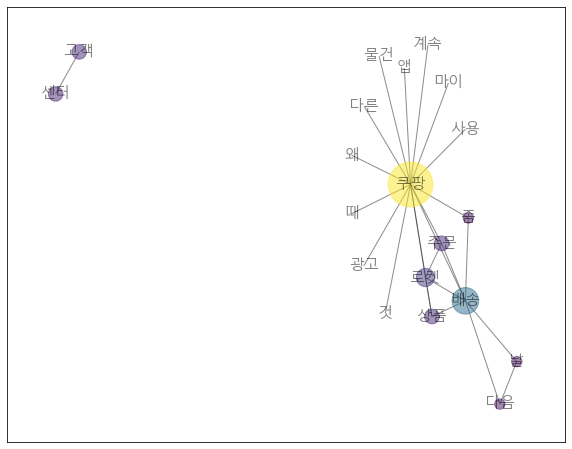

In [55]:
# 한글폰트 설정
from matplotlib import font_manager
font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()

plt.figure(figsize=(10, 8))
nx.draw_networkx(gra, node_color=list(prk.values()), node_size=nsize,
                 alpha=0.5, edge_color='0.1', #cmap=plt.cm.YlGn,
                 font_family=font_family,font_size=15)
plt.draw()